In [131]:
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from conf.core import Connection
from conf.tracer import TraceConnection
from conf.influx import InfluxImpl, getTimestampsAndLengthAndDirection
import pyshark
from typing import List, Dict, Any
from conf.enums import PacketType, TransPortType
from conf.stats import ConnStats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [132]:
tracer = TraceConnection()

In [141]:
connections : List[Connection] = tracer.getConnections("zoom2Members.pcapng")

In [142]:
connections.sort(key=lambda x: len(x), reverse=True)

In [143]:
for conn in connections:
        print(conn.getConnKey(), conn.getSNI(), conn.connection_type, len(conn))
        #print(conn.getConnKey(), conn.getSNI(), conn.connection_type, len(conn))

('192.168.1.137', '134.224.146.92', '50392', '8801', 'UDP') None {<PacketType.DTLS: 1>, <PacketType.STUN: 4>} 10733
('192.168.1.137', '134.224.146.92', '61018', '8801', 'UDP') None {<PacketType.DTLS: 1>, <PacketType.STUN: 4>} 8012
('192.168.1.137', '134.224.146.92', '61005', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 6792
('192.168.1.137', '134.224.146.92', '60994', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 1440
('192.168.1.137', '170.114.46.1', '55003', '443', 'UDP') None {<PacketType.QUIC: 6>} 1322
('192.168.1.137', '134.224.146.92', '61004', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 542
('192.168.1.137', '134.224.146.92', '61001', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 455
('192.168.1.137', '134.224.146.92', '61002', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us {<PacketType.TCP: 7

In [144]:
def filterConnections(connections : List[Connection], connection_types : List[PacketType]):
    def doesContainConnectionTypes(connection : Connection, connection_types : List[PacketType]):
        for connection_type in connection_types:
            if connection_type not in connection.connection_type:
                return False
        return True
   
    return [connection for connection in connections if doesContainConnectionTypes(connection, connection_types)]

def combineConnections(connections : List[Connection], enforce_transport = False):
    if len(connections) == 0:
        return []
    combined_connection = Connection(src_ip=connections[0].src_ip, src_port=connections[0].src_port, dst_ip=connections[0].dst_ip, dst_port=connections[0].dst_port,transport_type= connections[0].transport_type)
    for connection in connections:
        if len(connection) == 0:
            continue
        if enforce_transport:
            assert connection.transport_type == combined_connection.transport_type, f"{connection.transport_type}, {combined_connection.transport_type}, {len(connection)}"
        for packet in connection.packet_stream:
            combined_connection.addPacket(packet)
    # important to sort it in order of timestamp
    combined_connection.packet_stream = sorted(combined_connection.packet_stream, key=lambda x: x.timestamp)
    return combined_connection

def printConns(connections : List[Connection]):
    def splitTimeString(time_str):
        return time_str.split("T")[1]
    for conn in connections:
        stat  = ConnStats(conn)
        print(conn.getConnKey(), conn.getSNI(), splitTimeString(stat.getStartTime()), splitTimeString(stat.getEndTime()),stat.getConnSpan(), stat.getUpStreamBytes(), stat.getDownStreamBytes(),conn.connection_type, len(conn))

In [145]:
tls_connections = filterConnections(connections, [PacketType.TLS])
quic_connections = filterConnections(connections, [PacketType.QUIC])
dtls_connections = filterConnections(connections, [PacketType.DTLS])
tcp_connections = filterConnections(connections, [PacketType.TCP])
rtp_connections = filterConnections(connections, [PacketType.RTP])

In [146]:
def getGoogleMeetPlottingConnections(connections):
    tls_connections = filterConnections(connections, [PacketType.TLS])
    quic_connections = filterConnections(connections, [PacketType.QUIC])
    rtp_connections = filterConnections(connections, [PacketType.RTP])

    only_stun_conns = combineConnections(list(filter(lambda x : len(x) > 0 and x.transport_type == TransPortType.UDP, [ conn.getSubConnection(packet_types= [PacketType.STUN]) for conn in connections])))
    only_media_conns =  [conn.getSubConnection(packet_types= [PacketType.RTP]) for conn in connections]
    only_media_conns = combineConnections(list(filter(lambda x : len(x) > 0, only_media_conns)))

    tls_connections = list(filter(lambda x : x.getSNI() != None and "google" in x.getSNI().lower(), tls_connections))
    printConns(tls_connections)
    gmeet_tls_combined = combineConnections(tls_connections, enforce_transport= True)
    gmeet_quic_combined = combineConnections(quic_connections, enforce_transport= True)
    gmeet_setup_conns = combineConnections(tls_connections,quic_connections)
    return gmeet_setup_conns,only_stun_conns,only_media_conns


def getZoomPlottingConnections(connections):
    tls_connections = filterConnections(connections, [PacketType.TLS])
    dtls_connections = filterConnections(connections, [PacketType.DTLS])
    quic_connections = filterConnections(connections, [PacketType.QUIC])

    only_stun_conns = combineConnections(list(filter(lambda x : len(x) > 0 and x.transport_type == TransPortType.UDP, [ conn.getSubConnection(packet_types= [PacketType.STUN]) for conn in connections])))
    only_media_conns =  [conn.getSubConnection(packet_types= [PacketType.DTLS]) for conn in connections]
    only_media_conns = combineConnections(list(filter(lambda x : len(x) > 0, only_media_conns)))

    tls_connections = list(filter(lambda x : x.getSNI() != None and "zoom" in x.getSNI().lower(), tls_connections))
    tls_combined = combineConnections(tls_connections, enforce_transport= True)
    quic_combined = combineConnections(quic_connections, enforce_transport= True)
    setup_conns = combineConnections(tls_connections,quic_connections)
    return setup_conns,only_stun_conns,only_media_conns

def getTeamsPlottingConnections(connections):
    tls_connections = filterConnections(connections, [PacketType.TLS])
    quic_connections = filterConnections(connections, [PacketType.QUIC])
    rtp_connections = filterConnections(connections, [PacketType.RTP])

    only_stun_conns = combineConnections(list(filter(lambda x : len(x) > 0 and x.transport_type == TransPortType.UDP, [ conn.getSubConnection(packet_types= [PacketType.STUN]) for conn in connections])))
    only_media_conns =  [conn.getSubConnection(packet_types= [PacketType.RTP]) for conn in connections]
    only_media_conns = combineConnections(list(filter(lambda x : len(x) > 0, only_media_conns)))

    tls_connections = list(filter(lambda x : x.getSNI() != None and ("microsoft" in x.getSNI().lower() or "office" in x.getSNI().lower()), tls_connections))
    tls_combined = combineConnections(tls_connections, enforce_transport= True)
    quic_combined = combineConnections(quic_connections, enforce_transport= True)
    setup_conns = combineConnections(tls_connections,quic_connections)
    return setup_conns,only_stun_conns,only_media_conns




In [140]:
setup_conns, stun_conns, media_conns = getGoogleMeetPlottingConnections(connections= connections)

('192.168.1.137', '17.253.67.196', '60212', '80', 'TCP') proxy-safebrowsing.googleapis.com 21:10:19.746052+11:00 21:11:20.467043+11:00 60.720990896224976 3343 33495 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 65
('192.168.1.137', '142.250.66.202', '63727', '443', 'TCP') scone-pa.clients6.google.com 21:10:41.277773+11:00 21:12:11.833382+11:00 90.55560898780823 6614 4599 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 33


In [147]:
setup_conns, stun_conns, media_conns = getZoomPlottingConnections(connections= connections)

In [124]:
setup_conns, stun_conns, media_conns = getTeamsPlottingConnections(connections= connections)

In [148]:
printConns(connections= tls_connections)

('192.168.1.137', '134.224.146.92', '61005', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:24.892438+11:00 15:21:13.105212+11:00 168.21277403831482 4436618 184559 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 6792
('192.168.1.137', '134.224.146.92', '60994', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:17.995428+11:00 15:21:13.105270+11:00 175.10984182357788 101191 156623 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 1440
('192.168.1.137', '134.224.146.92', '61004', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:24.441241+11:00 15:21:13.105182+11:00 168.66394090652466 27488 26704 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 542
('192.168.1.137', '134.224.146.92', '61001', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:23.127622+11:00 15:21:13.105085+11:00 169.97746300697327 24734 20995 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 455
('192.168.1.137', '134.224.146.92', '61002', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:23.549200+11:00 15:21:13.1051

In [180]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
#matplotlib.style.use('classic')
import pandas as pd
from collections import OrderedDict

class ConnectionPlotter:
    def __init__(self, alpha=0.6, figsize=(10, 6),marker_size = 15):
        self.alpha = alpha
        self.figsize = figsize
        self.upload_marker = '^'  # Triangle Up for Upload
        self.download_marker = 'v'  # Triangle Down for Download
        self.colors = plt.get_cmap("tab10").colors  # Get distinct colors for each connection
        self.marker_size = marker_size
    def plotConnections(self, connections,labels,title= "fill title"):
        """Plots multiple connections on the same figure with a shared x-axis."""

        if not connections:
            print("No connections to plot.")
            return
        assert len(connections) == len(labels)

        fig, ax = plt.subplots(figsize=self.figsize)

        for i, connection in enumerate(connections):
            timestamps, lengths, direction = getTimestampsAndLengthAndDirection(connection)
            timestamps = pd.to_datetime(timestamps)

            color = self.colors[i % len(self.colors)]
            # Print first and last timestamps for debugging
            #print(f"Connection {i}: {timestamps.iloc[0]} to {timestamps.iloc[-1]}")

            # Convert to NumPy array for efficient filtering
            timestamps = np.array(timestamps)
            lengths = np.array(lengths)
            direction = np.array(direction)

            # Separate upload (0) and download (1) packets
            upload_mask = direction == 0
            download_mask = direction == 1

            # Plot upload packets
            ax.scatter(timestamps[upload_mask], lengths[upload_mask], alpha=self.alpha, 
                       marker=self.upload_marker, label=f"{labels[i]}-upload", color=color, s = self.marker_size)

            # Plot download packets
            ax.scatter(timestamps[download_mask], lengths[download_mask], alpha=self.alpha, 
                       marker=self.download_marker, label=f"{labels[i]}-download", color=color, s = self.marker_size)

        ax.set(xlabel="Time", ylabel="Packet Length", title= title)
        ax.grid(True)

        # Format x-axis correctly
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
        fig.autofmt_xdate()

        # Avoid duplicate legends by grouping unique labels
        handles, labels = ax.get_legend_handles_labels()

        # Remove duplicates while maintaining order
        unique_legend = list(OrderedDict(zip(labels, handles)).items())

        # Unpack back into two lists
        unique_labels, unique_handles = zip(*unique_legend)

        ax.legend(unique_handles, unique_labels, loc="upper right", ncols=2)
        ax.set_ylim(0,1800)
        plt.savefig("zoomTLSScreenSharing.pdf", dpi= 300,bbox_inches='tight',format = "pdf")
        plt.show()


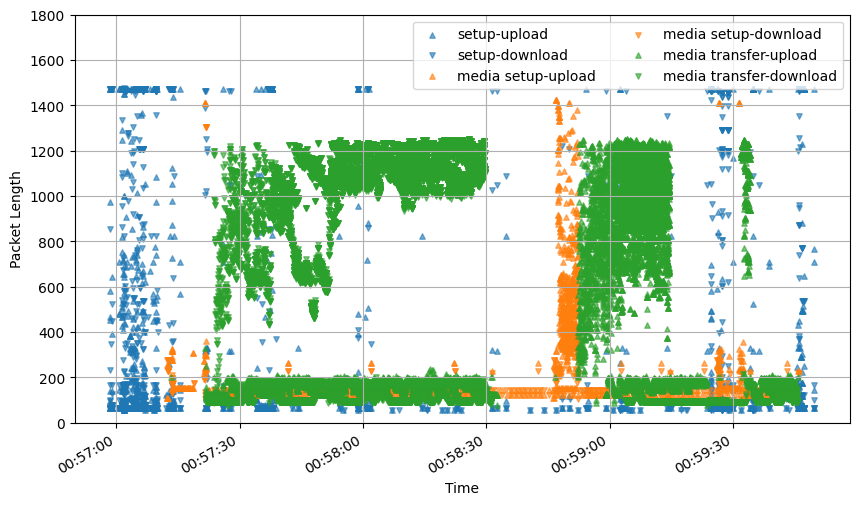

In [130]:
ConnectionPlotter().plotConnections([setup_conns,stun_conns,media_conns], ["setup","media setup", "media transfer"], "")

In [171]:
index = 3
conns = tls_connections[index:index + 1]

In [172]:
printConns(conns)

('192.168.1.137', '134.224.146.92', '61001', '443', 'TCP') zoomsg13422414692rwg.cloud.zoom.us 15:18:23.127622+11:00 15:21:13.105085+11:00 169.97746300697327 24734 20995 {<PacketType.TCP: 7>, <PacketType.TLS: 0>} 455


In [176]:
conns = tls_connections[:4]

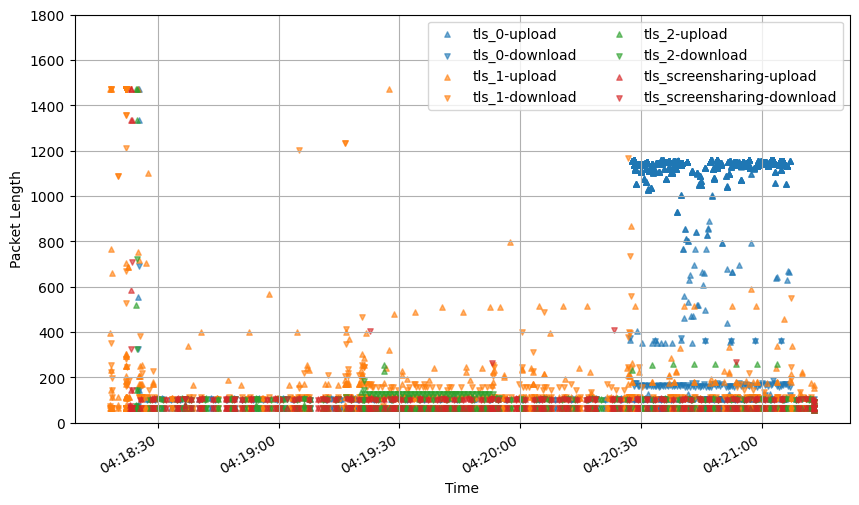

In [181]:
ConnectionPlotter().plotConnections(connections= conns, labels= [f"tls_{i}" for i in range(len(conns) -1)] + ["tls_screensharing"], title= "")

In [ ]:
influx_impl = InfluxImpl()

In [21]:
for i in range(2):
    influx_impl.delete(measurement= f"gmeet_rtp_{i}")
    influx_impl.write(connection= rtp_connections[i], measurement_name= f"gmeet_rtp_{i}", tag_columns= ["direction"])

Data deleted successfully.
Data deleted successfully.


In [56]:
for i in range(1):
    influx_impl.delete(measurement= f"gmeet_quic_{i}")
    influx_impl.write(connection= gmeet_quic_combined, measurement_name= f"gmeet_quic_{i}", tag_columns= ["direction"])

Data deleted successfully.
